<a href="https://colab.research.google.com/github/shazzad-hasan/practice-deep-learning-with-pytorch/blob/main/variational_autoencoder/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import torch
import torchvision

import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print("CUDA is available!")
else:
  print("CUDA is not available!")

device = torch.device('cuda') if train_on_gpu else torch.device('cpu')

CUDA is available!


In [3]:
# set up the general configeration
def set_all_seeds(seed):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

random_seed = 125
set_all_seeds(random_seed)

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()
# load dataset from torchvision.datasets module
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# number of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# print out some data stats

print("Number of training images: ", len(train_data))
print("Number of test images: ", len(test_data))

for inputs, _ in train_loader:
  print("Image batch dimension: ", inputs.shape)
  break

Number of training images:  60000
Number of test images:  10000
Image batch dimension:  torch.Size([20, 1, 28, 28])


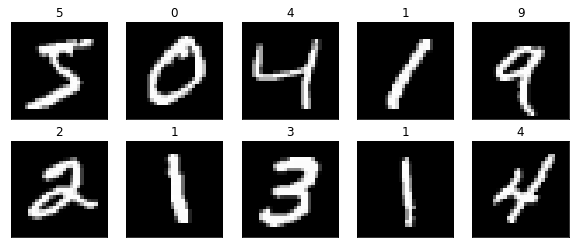

In [6]:
# visualize a batch of training data
def imshow(img):
  plt.imshow(np.squeeze(img), cmap="gray")

# obtain one batch of training images
dataiter = iter(train_loader)
inputs, targets = dataiter.next()
inputs = inputs.numpy()

# plot some images
fig = plt.figure(figsize=(10,4))
for idx in np.arange(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  imshow(inputs[idx])
  ax.set_title(str(targets[idx].item()))

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5*log_var)
            eps = torch.randn_like(std)
            sample = eps.mul(std).add_(mu) # sampling
            return sample
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var) # latent vector
        recon_input = self.decode(z)
        return recon_input, mu, log_var

model = VAE()
model.to(device)
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)


In [8]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# specify optimizer
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001)

In [9]:
# num of epochs to train the model
num_epochs = 20

# track training loss
train_losses = []

for epoch in range(num_epochs):
  # running train loss
  running_train_loss = 0.0
  for batch_idx, data in enumerate(train_loader):
      inputs, _ = data
      inputs = inputs.to(device)
      optimizer.zero_grad()
      recon_batch, mu, logvar = model(inputs)
      loss = loss_function(recon_batch, inputs, mu, logvar)
      loss.backward()
      optimizer.step()
      running_train_loss += loss.item()

  # calculate avg loss over an epoch
  running_train_loss = running_train_loss / len(train_loader)
  train_losses.append(running_train_loss)

  print("Epoch: {} \tTraining loss: {:.6f}".format(epoch+1, running_train_loss))

print("Finished training!")

Epoch: 1 	Training loss: 2642.976648
Epoch: 2 	Training loss: 2253.354992
Epoch: 3 	Training loss: 2199.623115
Epoch: 4 	Training loss: 2175.119452
Epoch: 5 	Training loss: 2158.728556
Epoch: 6 	Training loss: 2146.353297
Epoch: 7 	Training loss: 2137.073839
Epoch: 8 	Training loss: 2129.717889
Epoch: 9 	Training loss: 2123.513316
Epoch: 10 	Training loss: 2117.454653
Epoch: 11 	Training loss: 2112.240447
Epoch: 12 	Training loss: 2108.758100
Epoch: 13 	Training loss: 2103.988774
Epoch: 14 	Training loss: 2101.332659
Epoch: 15 	Training loss: 2097.934948
Epoch: 16 	Training loss: 2096.065584
Epoch: 17 	Training loss: 2092.214662
Epoch: 18 	Training loss: 2089.510381
Epoch: 19 	Training loss: 2087.770279
Epoch: 20 	Training loss: 2085.533441
Finished training!


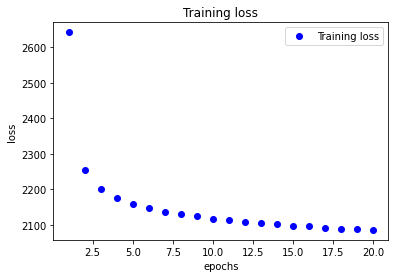

In [10]:
# plot training loss for each epoch
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training loss')
plt.legend()
plt.show()

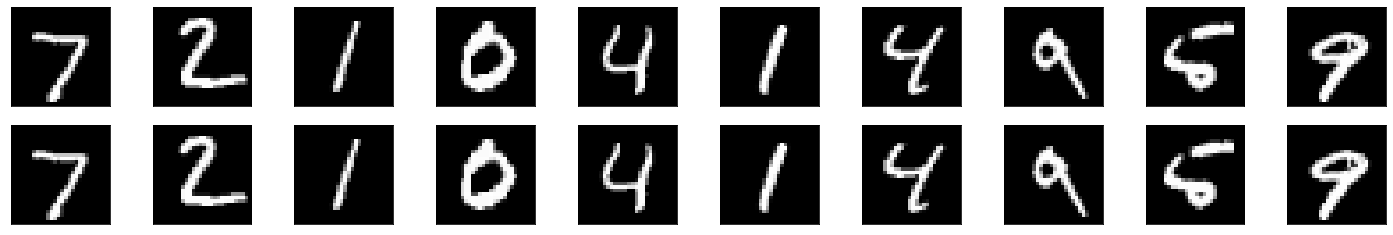

In [11]:
# visualize one batch of test images along with their reconstruction

# obtain one batch of test images
dataiter = iter(test_loader)
inputs, _ = dataiter.next()

# flatten images
flatten_inputs = inputs.view(inputs.size(0), -1)
flatten_inputs = flatten_inputs.to(device)
# get sample outputs
recons_imgs, _, _ = model(flatten_inputs)
# resize outputs into a batch of images
outputs = recons_imgs.view(batch_size, 1, 28, 28)

# display some inputs and their reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([inputs, outputs], axes):
  for img, ax in zip(inputs, row):
    # prepare images for display
    img = np.squeeze(img.numpy()) if not train_on_gpu else np.squeeze(img.cpu().numpy())
    ax.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)